# Bond Returns

_UNDER CONSTRUCTION_


- PCA
- bond portfolio returns


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.api as sm
from finds.readers import Alfred
from finds.misc import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)
imgdir = paths['images'] / 'ts'

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

Bond Return Components

In [3]:
## get Merrill Lynch bond indexes
c = alf.get_category(32413)
print(c['id'], c['name'])
t = Series({s['id']: s['title'] for s in c['series']})
t

https://api.stlouisfed.org/fred/category?category_id=32413&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json
https://api.stlouisfed.org/fred/category/children?category_id=32413&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json
https://api.stlouisfed.org/fred/category/series?category_id=32413&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json&offset=0
https://api.stlouisfed.org/fred/category/series?category_id=32413&api_key=eb428f329807459fa7bee89be4ebbc3b&file_type=json&offset=1000
32413 BofA Merrill Lynch Total Bond Return Index Values


BAMLCC0A0CMTRIV             ICE BofA US Corporate Index Total Return Index...
BAMLCC0A1AAATRIV            ICE BofA AAA US Corporate Index Total Return I...
BAMLCC0A2AATRIV             ICE BofA AA US Corporate Index Total Return In...
BAMLCC0A3ATRIV              ICE BofA Single-A US Corporate Index Total Ret...
BAMLCC0A4BBBTRIV            ICE BofA BBB US Corporate Index Total Return I...
BAMLCC1A013YTRIV            ICE BofA 1-3 Year US Corporate Index Total Ret...
BAMLCC2A035YTRIV            ICE BofA 3-5 Year US Corporate Index Total Ret...
BAMLCC3A057YTRIV            ICE BofA 5-7 Year US Corporate Index Total Ret...
BAMLCC4A0710YTRIV           ICE BofA 7-10 Year US Corporate Index Total Re...
BAMLCC7A01015YTRIV          ICE BofA 10-15 Year US Corporate Index Total R...
BAMLCC8A015PYTRIV           ICE BofA 15+ Year US Corporate Index Total Ret...
BAMLEM1BRRAAA2ACRPITRIV     ICE BofA AAA-A Emerging Markets Corporate Plus...
BAMLEM1RAAA2ALCRPIUSTRIV    ICE BofA AAA-A US Emerging Markets L

In [4]:
b = []   # accumulate bond returns
for s in t.index:
    b.append(alf(s, start=19961231) )
bonds = pd.concat(b, axis=1)

In [5]:
## Show blocks of data available
v = bonds.notna().sum(axis=1).rename('count')
v = pd.concat([v, (v != v.shift()).cumsum().rename('notna')], axis=1)
g = v.reset_index().groupby(['notna', 'count'])['date'].agg(['first','last'])
g

,,first,last
notna,count,,
1,15,19961231,19971230
2,16,19971231,19981230
3,33,19981231,20031230
4,48,20031231,20181108
5,46,20181109,20181109
6,48,20181112,20230829


In [6]:
start_date = 19981231
rets = bonds.loc[bonds.index >= start_date,
                 bonds.loc[start_date].notna().values]
rets = pd.concat([alf.transform(rets[col], log=1, diff=1)
                  for col in rets.columns], axis=1)
show(Series(alf.header(rets.columns),
            index=rets.columns,
            name='title').to_frame().rename_axis('series'),
     max_colwidth=88,
     caption="Bond Index Total Returns")

,title
Bond Index Total Returns,
BAMLCC0A0CMTRIV,ICE BofA US Corporate Index Total Return Index...
BAMLCC0A1AAATRIV,ICE BofA AAA US Corporate Index Total Return I...
BAMLCC0A2AATRIV,ICE BofA AA US Corporate Index Total Return In...
BAMLCC0A3ATRIV,ICE BofA Single-A US Corporate Index Total Ret...
BAMLCC0A4BBBTRIV,ICE BofA BBB US Corporate Index Total Return I...
BAMLCC1A013YTRIV,ICE BofA 1-3 Year US Corporate Index Total Ret...
BAMLCC2A035YTRIV,ICE BofA 3-5 Year US Corporate Index Total Ret...
BAMLCC3A057YTRIV,ICE BofA 5-7 Year US Corporate Index Total Ret...
BAMLCC4A0710YTRIV,ICE BofA 7-10 Year US Corporate Index Total Re...


In [7]:
# Marginal Variance Explained
x = np.array(rets.iloc[1:].replace(np.nan, 0))
d = rets.iloc[1:].index.rename(None)
c = rets.columns
r = 3
"""
from finds.alfred import marginalRsq
mR2 = marginalRsq(x, standardize=True)
print(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"
      f" ({len(x)} obs)")
df = DataFrame({'explained': np.mean(mR2, axis=1)},
               index=np.arange(1, len(mR2) + 1))
df.iloc[4]
"""

'\nfrom finds.alfred import marginalRsq\nmR2 = marginalRsq(x, standardize=True)\nprint(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"\n      f" ({len(x)} obs)")\ndf = DataFrame({\'explained\': np.mean(mR2, axis=1)},\n               index=np.arange(1, len(mR2) + 1))\ndf.iloc[4]\n'

In [8]:
## Same calculation with sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
pipe.fit(x)
print(pipe.named_steps['pca'].explained_variance_ratio_)  # sanity check
scree = Series(pipe.named_steps['pca'].explained_variance_ratio_,
               index=np.arange(1, x.shape[1]+1))

[5.86789902e-01 1.86999891e-01 7.70507495e-02 2.31692776e-02
 2.09236720e-02 1.74466819e-02 1.59969576e-02 1.11997496e-02
 1.08857821e-02 9.62694118e-03 7.23593993e-03 5.86580950e-03
 5.18815697e-03 4.67376507e-03 4.08324626e-03 2.59381179e-03
 2.45324538e-03 2.30697359e-03 1.37010289e-03 9.79850816e-04
 8.05769526e-04 6.38160060e-04 4.08352451e-04 3.82511512e-04
 3.14728492e-04 2.77963772e-04 9.32990978e-05 8.59047248e-05
 5.50770945e-05 4.00939820e-05 3.59304585e-05 1.58570390e-05
 5.84577715e-06]


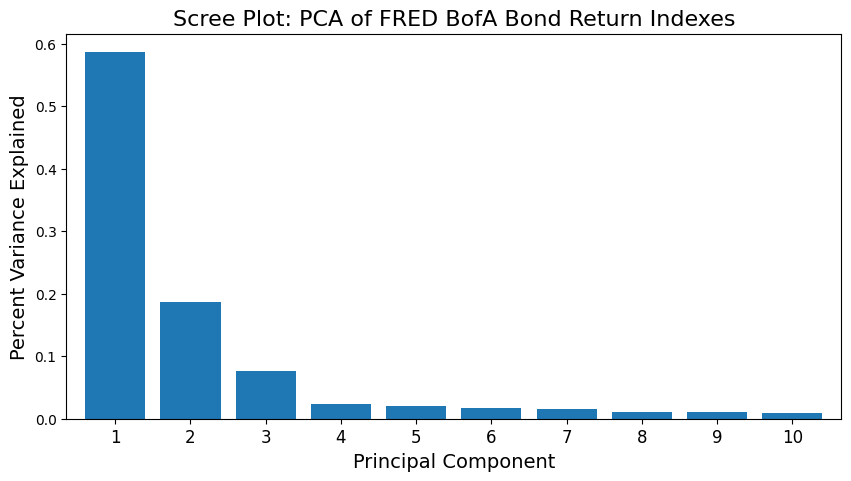

In [9]:
## Scree plot
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
scree[:10].plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: PCA of FRED BofA Bond Return Indexes', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_ylabel("Percent Variance Explained", fontsize=14)
ax.set_xlabel("Principal Component", fontsize=14)
plt.savefig(imgdir / 'scree.jpg')

In [10]:
# Rsquare of components explained by Interest Rate Indicators
rates = ['BAA10Y', 'T10Y2Y', 'DGS10']  # compare rate levels
rates = pd.concat([alf(s) for s in rates], axis=1).reindex(d).pad()
rates.index = pd.DatetimeIndex(rates.index.astype(str), freq='infer')

/tmp/ipykernel_4082727/620974196.py:3: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  rates = pd.concat([alf(s) for s in rates], axis=1).reindex(d).pad()


In [11]:
factors = DataFrame(pipe.transform(x)[:, :3],
                    columns=np.arange(1, 4),
                    index=pd.DatetimeIndex(d.astype(str), freq='infer'))

In [12]:
rsq = [sm.OLS(factors[col].cumsum(), rates).fit().rsquared
       for col in factors.columns]
res = DataFrame({'Rsq of rate levels': rsq}, index=factors.columns)
res['Rsq of rate changes'] = [sm.OLS(factors[col],
                                      rates.diff().fillna(0))\
                               .fit().rsquared
                               for col in factors.columns]
show(res, max_colwidth=75, 
     caption="R-squared of each PC explained by Interest Rate Indicators")

,Rsq of rate levels,Rsq of rate changes
R-squared of each PC explained by Interest Rate Indicators,,
1,0.7131,0.5263
2,0.2942,0.5016
3,0.9211,0.0499


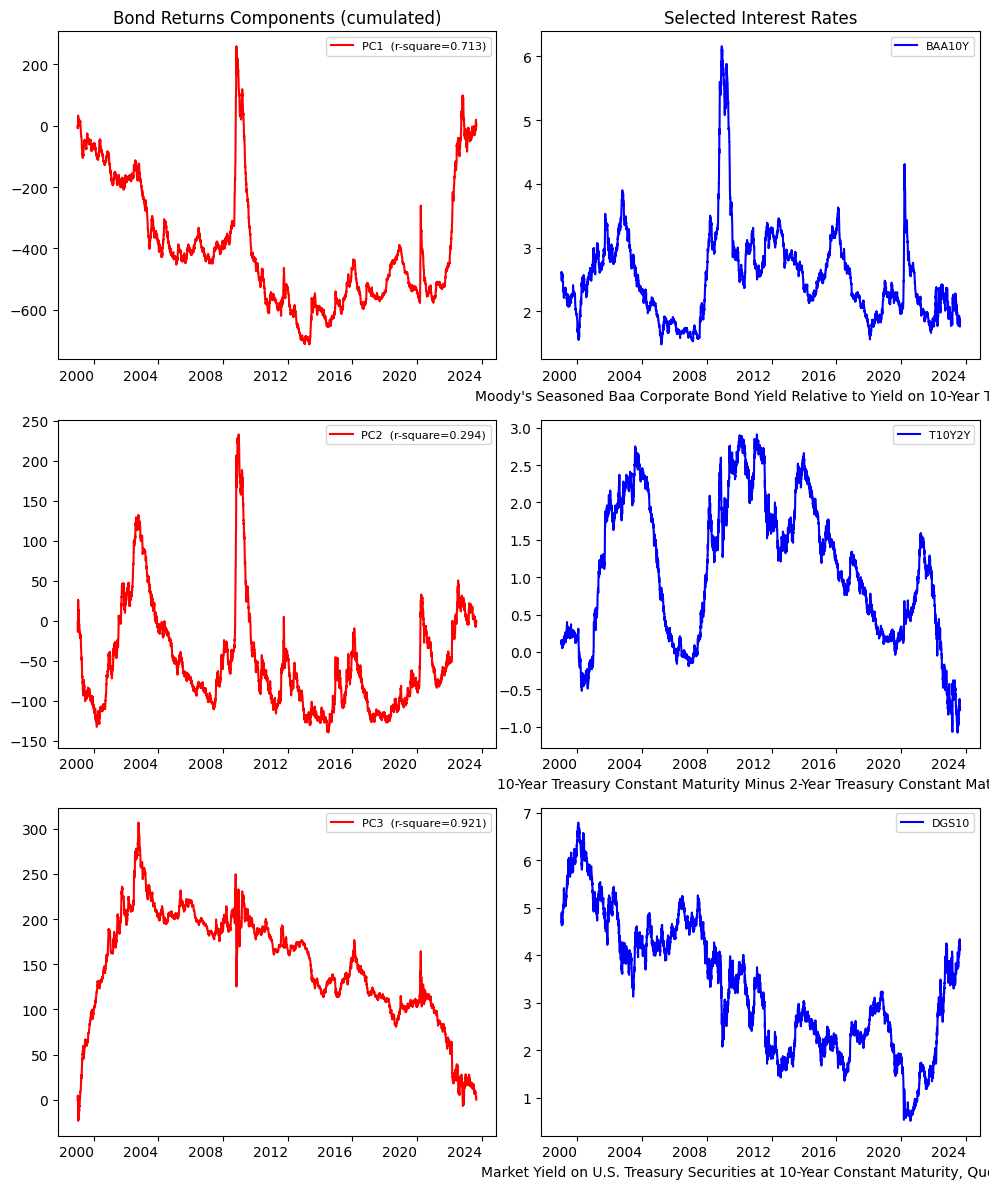

In [13]:
# Plot of cumulative components and interest rates levels
fig = plt.figure(figsize=(10, 12), num=1, clear=True)
for isub, col in enumerate(factors.columns):
    ax = fig.add_subplot(3, 2, (col * 2) - 1)
    flip = -1 if col == 3 else 1
    (flip*factors[col]).cumsum().plot(ax=ax, color='r')
    ax.legend([f"PC{col}  (r-square={rsq[isub]:.3})"], fontsize=8)
    ax.xaxis.set_tick_params(rotation=0)
    if not isub:
        ax.set_title('Bond Returns Components (cumulated)')
        
    ax = fig.add_subplot(3, 2, (isub + 1) * 2)
    rates.iloc[:, isub].plot(ax=ax, color='b')
    ax.legend([f"{rates.columns[isub]}"], fontsize=8)
    ax.xaxis.set_tick_params(rotation=0)
    if not isub:
        ax.set_title('Selected Interest Rates')
    ax.set_xlabel(alf.header(rates.columns[isub])[:80])
plt.savefig(imgdir / 'components.jpg')
plt.tight_layout()